>**Import Statements**

In [8]:
import cv2
import os
import random
import zipfile
import numpy as np
from matplotlib import pyplot as plt

In [9]:
!pip install -U tensorflow-addons

In [10]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50

> **Function for showing an image**

In [11]:
def show_image(img, shape, label, cmap='gray'):
    plt.subplot(3, 6, 1)
    plt.title(label)
    plt.imshow(img.reshape(shape), cmap=cmap)
    plt.subplots_adjust(right=1.2, top=1.2)
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',
                    top='off', right='off', left='off', which='both')
    plt.show()

> ***Reading in the LFW dataset***

In [12]:
from sklearn.datasets import fetch_lfw_people

In [13]:
lfw_dataset = fetch_lfw_people(min_faces_per_person=10, resize=0.5, color = True)

In [14]:
lfw_faces = lfw_dataset.images
targets = lfw_dataset.target
target_names = lfw_dataset.target_names

# image shape
image_shape = (200 , 200 , 3)

# adding image names
lfw_names = []
for target in targets:
    name = target_names[target]
    lfw_names.append(name)

resized_images = []
for image in lfw_dataset.images:
    resized_image = cv2.resize(image, (image_shape[0], image_shape[1]))
    resized_images.append(resized_image / np.max(resized_image))
    
lfw_names = np.array(lfw_names)
lfw_faces = np.array(resized_images)


(200, 200, 3)


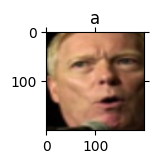

In [15]:
import random

random_index = random.randint(0 , targets.size)

print(image_shape)

test_image = lfw_faces[random_index]
test_name = lfw_names[random_index]

show_image(test_image , image_shape , 'a' , 'jet')

> ***Loading students images***

In [16]:
# load the faces of our classmates
class_dataset = '/kaggle/input/cropped/cropped_dataset'

# class mates
class_mates = os.listdir(class_dataset)
class_mates.sort()

# remove dummy directory
class_mates.remove('abebe kebede_s photo')
print(f'There are {len(class_mates)} classmates.')

There are 50 classmates.


In [17]:
images = []
names = []

for class_mate in class_mates:
    class_mate_path = os.path.join(class_dataset , class_mate)
#     print(f'{class_mate} = {len(os.listdir(class_mate_path))}')
    class_mate_images = os.listdir(class_mate_path)
    
    for image in class_mate_images:
        image_path = os.path.join(class_mate_path , image)
        try:
            # read in the image
            current_image = cv2.imread(image_path , cv2.IMREAD_COLOR)
            
            # Convert BGR image to RGB
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)
            
            # resize the image to (62 , 47)
            current_image = cv2.resize(current_image , (image_shape[1] , image_shape[0]))
            
            # add the image
            images.append(current_image / np.max(current_image))
            
            # add the label
            names.append(class_mate)
            
        except Exception as e:
            print(f'{class_mate} - {image}')
            continue

# Convert our list of faces to numpy arrays
images = np.array(images)
names = np.array(names)

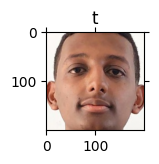

In [18]:
show_image(images[0] , image_shape , 't')

In [19]:
# # both
# combined_faces = np.concatenate([lfw_faces, images], axis=0)
# combined_names = np.concatenate([lfw_names, names], axis=0)

# class
combined_faces = np.concatenate([images], axis=0)
combined_names = np.concatenate([names], axis=0)

# # lfw
# combined_faces = np.concatenate([lfw_faces], axis=0)
# combined_names = np.concatenate([lfw_names], axis=0)

In [20]:
from sklearn.model_selection import train_test_split



# splitting
class_train , class_test , c_train_name , c_test_name = train_test_split(combined_faces , combined_names , test_size = 0.1 , random_state = 42)


train_dataset = tf.data.Dataset.from_tensor_slices((class_train , c_train_name)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((class_test , c_test_name)).batch(32)

> ***Building a CNN model***

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(image_shape[0],image_shape[1],3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 32)        0

> ***Train the model***

In [24]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    train_dataset,
    epochs=15,
    batch_size = 32)

Epoch 1/15


2024-02-04 23:03:02.444327: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707087787.481442      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 11s 143ms/step - loss: 0.9823
Epoch 2/15
15/15 [==============================] - 2s 101ms/step - loss: 0.9281
Epoch 3/15
15/15 [==============================] - 2s 100ms/step - loss: 0.8909
Epoch 4/15
15/15 [==============================] - 2s 101ms/step - loss: 0.8417
Epoch 5/15
15/15 [==============================] - 2s 101ms/step - loss: 0.8110
Epoch 6/15
15/15 [==============================] - 2s 101ms/step - loss: 0.7781
Epoch 7/15
15/15 [==============================] - 2s 102ms/step - loss: 0.7318
Epoch 8/15
15/15 [==============================] - 2s 101ms/step - loss: 0.6836
Epoch 9/15
15/15 [==============================] - 2s 101ms/step - loss: 0.6556
Epoch 10/15
15/15 [==============================] - 2s 103ms/step - loss: 0.6320
Epoch 11/15
15/15 [==============================] - 2s 101ms/step - loss: 0.5904
Epoch 12/15
15/15 [==============================] - 2s 101ms/step - loss: 0.5571
Epoch 13/15
15/15 [================

> ***Evaluate the model***

In [25]:
# Evaluate the network
results = model.predict(test_dataset)

2/2 [==============================] - 0s 270ms/step


In [26]:
import io

# Save test embeddings for visualization in projector
np.savetxt("vecs_faces.tsv", results, delimiter='\t')

out_m = io.open('meta_faces.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


> ***Now let us use this model to encode the faces of our classmates***

In [27]:
# load the faces of our classmates
class_dataset = '/kaggle/input/cropped/cropped_dataset'

# class mates
class_mates = os.listdir(class_dataset)
class_mates.sort()

# remove dummy directory
class_mates.remove('abebe kebede_s photo')
print(f'There are {len(class_mates)} classmates.')

There are 50 classmates.


In [28]:
print(image_shape)

(200, 200, 3)


In [29]:
images = []
names = []

for class_mate in class_mates:
    class_mate_path = os.path.join(class_dataset , class_mate)
#     print(f'{class_mate} = {len(os.listdir(class_mate_path))}')
    class_mate_images = os.listdir(class_mate_path)
    
    for image in class_mate_images:
        image_path = os.path.join(class_mate_path , image)
        try:
            # read in the image
            current_image = cv2.imread(image_path , cv2.IMREAD_COLOR)
            
            # Convert BGR image to RGB
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)
            
            # resize the image to (62 , 47)
            current_image = cv2.resize(current_image , (image_shape[1] , image_shape[0]))
            
            # add the image
            images.append(current_image / np.max(current_image))
            
            # add the label
            names.append(class_mate)
            
        except Exception as e:
            print(f'{class_mate} - {image}')
            continue

# Convert our list of faces to numpy arrays
images = np.array(images)
names = np.array(names)

# create a tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, names))
class_mates_dataset = dataset.batch(32)

In [30]:
print(names.shape)

(516,)


> ***Just checking out whether the images where resized properly***

(200, 200, 3)


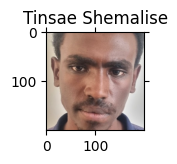

In [31]:
random_index = 411
random_image = images[random_index]
random_label = names[random_index]

print(image_shape)
show_image(random_image , image_shape , random_label)

> ***Incode all of classmates images***

In [32]:
database = model.predict(class_mates_dataset)
print(database.shape)

17/17 [==============================] - 1s 30ms/step
(516, 256)


> ***Save the encodings and the labels***

In [33]:
# Save test embeddings for visualization in projector
np.savetxt("class_mates_inception.tsv", database, delimiter='\t')

out_m = io.open('class_mates_label.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(class_mates_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()
print('----Saving Done----')

----Saving Done----


> ***Use SVM to separate the encodings***

In [34]:
from sklearn import svm

X_train , X_test , y_train , y_test = train_test_split(database , names , test_size=0.2 , random_state = 3)

In [35]:
svm_clf = svm.SVC()

param_grid = {'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10]}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(svm_clf, param_grid, scoring='accuracy', cv=5, verbose=1)

# Fit the grid search on the training set
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Predict the labels on the test set
y_pred = grid_search.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

# Print the accuracy and the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'C': 0.1, 'gamma': 10, 'kernel': 'poly'}
Best score: 0.975668527769615
Accuracy: 0.9711538461538461
Classification report:
                      precision    recall  f1-score   support

Abdurahman Muhammed       1.00      1.00      1.00         4
  Abraham Wendmeneh       1.00      1.00      1.00         1
     Amanuel Beyene       1.00      1.00      1.00         1
       Amir Ahmedin       1.00      1.00      1.00         2
   Ananiya_Tesfahun       1.00      1.00      1.00         2
     Betelhem Yimam       1.00      1.00      1.00         2
   Bethelhem Yemane       1.00      1.00      1.00         3
      Biniyam Haile       0.50      1.00      0.67         1
      Dawit Getahun       1.00      1.00      1.00         4
        Dawit_Abebe       1.00      1.00      1.00         1
    Deribew_Shimels       1.00      1.00      1.00         3
     Ephrem_Shimels       1.00      1.00      1.00         5
  

> Testing

In [36]:
test_path = '/kaggle/input/tinsae'
images = os.listdir(test_path)

test_images = []
test_names = []

for image in images:
    path = os.path.join(test_path , image)
    picture = cv2.imread(path , cv2.IMREAD_COLOR)
    
    picture = cv2.cvtColor(picture , cv2.COLOR_BGR2RGB)
    picture = cv2.resize(picture , (image_shape[1] , image_shape[0]))

    picture_shape = picture.shape
    
    test_images.append(picture)
    test_names.append(image)
    
test_images = np.array(test_images)
test_names = np.array(test_names)


test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_names))
test_dataset = test_dataset.batch(32)


> ***Cropping out the faces***

face shape (200, 200, 3)


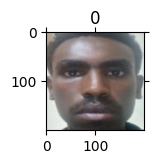

face shape (200, 200, 3)


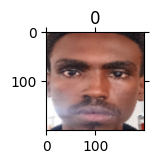

face shape (200, 200, 3)


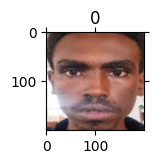

face shape (200, 200, 3)


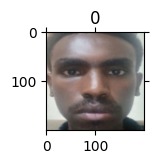

In [39]:
cropped = []

# Load the pre-trained face detector
face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
for image in test_images:
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    # Process each detected face
    for i, (x, y, w, h) in enumerate(faces):
        face_roi = image[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi , (image_shape[1] , image_shape[0]))
        print(f'face shape {face_roi.shape}')
#         output_path = os.path.join('', f"{random.randint(0 , 1000)}.jpg")
#         cv2.imwrite(output_path , cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))
        cropped.append(face_roi)
        show_image(face_roi , face_roi.shape , i)
    
    
cropped = np.array(cropped)

> ***Encoding the faces***

In [40]:
encodings = model.predict(cropped)

1/1 [==============================] - 0s 75ms/step


In [41]:
prediction = grid_search.predict(encodings)

In [42]:
prediction

array(['Biniyam Haile', 'Fraol Mulugeta', 'Sosina Esayas',
       'Biniyam Haile'], dtype='<U19')

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming encodings and database are numpy arrays of shape (num_faces, embedding_dim)
# Normalize encodings and database embeddings
encodings_normalized = encodings / np.linalg.norm(encodings, axis=1, keepdims=True)
database_normalized = database / np.linalg.norm(database, axis=1, keepdims=True)

# Compute cosine similarity between encodings and database
similarities = cosine_similarity(encodings_normalized, database_normalized)

# Find the index of the closest match for each encoding
closest_matches = np.argmax(similarities, axis=1)

# Assuming closest_matches is an array of indices of the closest matches in the database
print(closest_matches)

[359  26 389 359]


In [48]:
test_path = '/kaggle/input/wholetest/A TEST SET'
test_names = os.listdir(test_path)

test_names.sort()

test_images = []
image_names = []

for test_name in test_names:
    folder_path = os.path.join(test_path , test_name)
    images = os.listdir(folder_path)
    
    for image in images:
        read_image = cv2.imread(os.path.join(folder_path , image) , cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(read_image, cv2.COLOR_BGR2GRAY)
        
        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

        # Process each detected face
        for i, (x, y, w, h) in enumerate(faces):
            face_roi = read_image[y:y+h, x:x+w]
            face_roi = cv2.resize(face_roi , (image_shape[1] , image_shape[0]))
            face_roi = cv2.cvtColor(face_roi , cv2.COLOR_BGR2RGB)
#             print(f'face shape {face_roi.shape}')
            test_images.append(face_roi)
            image_names.append(test_name)
#             show_image(face_roi , face_roi.shape , test_name)

test_images = np.array(test_images)
image_names = np.array(image_names)

Invalid SOS parameters for sequential JPEG


In [49]:
test_embedding = model.predict(test_images)

1/1 [==============================] - 0s 432ms/step


In [50]:
test_predictions = grid_search.predict(test_embedding)

In [51]:
from sklearn.metrics import accuracy_score

score = accuracy_score(image_names , test_predictions)

print(f'Accuracy : {score}')
print(f'Real_name : {image_names}')
print(f'Predicted_name : {test_predictions}')

Accuracy : 0.3333333333333333
Real_name : ['Abraham Wendmeneh' 'Betelhem Yimam' 'Betelhem Yimam' 'Dawit Getahun'
 'Dawit Getahun' 'Esayas Nigussie' 'Esayas Nigussie' 'Etsubdink Awoke'
 'Etsubdink Awoke' 'Fraol Mulugeta' 'Gedion Ezra' 'Geleta Daba T'
 'Geleta Daba T' 'Mariam Yohannes T' 'Mariam Yohannes T' 'Olyad Temesgen'
 'Olyad Temesgen' 'Sahib Semahegn T' 'Sahib Semahegn T' 'Tewodros Berhanu'
 'Tewodros Berhanu' 'Tinsae Shemelaise' 'Tinsae Shemelaise'
 'Yanet Mekuria' 'Yohannes Dessie' 'Yohannes Dessie' 'Yonas Engedu T'
 'Yonas Engedu T' 'Yosef Muluneh' 'Yosef Muluneh']
Predicted_name : ['Abraham Wendmeneh' 'Betelhem Yimam' 'Betelhem Yimam' 'Geleta Daba'
 'Sahib Semahegn' 'Esayas Nigussie' 'Esayas Nigussie' 'Etsubdink Awoke'
 'Kidus Hunegnaw' 'Abraham Wendmeneh' 'Sosina Esayas' 'Geleta Daba'
 'Geleta Daba' 'Mariam Yohannes' 'Mariam Yohannes' 'Olyad Temesgen'
 'Olyad Temesgen' 'Sahib Semahegn' 'Milion Tolesa' 'Leul Wujira'
 'Leul Wujira' 'Biniyam Haile' 'Biniyam Haile' 'Feven Tesfaye

In [52]:
import pickle

pickle.dump(model, open('siamese_model_1.pkl', 'wb'))